In [1]:
import pandas as pd
import numpy as np
import logging
import time
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import display

# Setup logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


In [2]:
# Step 1: Load CSVs with Correct Delimiters
try:
    shareprices_df = pd.read_csv("us-shareprices-daily.csv", sep=";")
    companies_df = pd.read_csv("us-companies.csv", sep=";")
    income_df = pd.read_csv("us-income-quarterly.csv", sep=";")
    
    # Convert column names to lowercase
    shareprices_df.columns = shareprices_df.columns.str.lower()
    companies_df.columns = companies_df.columns.str.lower()
    income_df.columns = income_df.columns.str.lower()
    
    logging.info("✅ Data loaded successfully!")
    print("📌 Raw Share Prices Data:")
    display(shareprices_df.head())
    print("📌 Raw Companies Data:")
    display(companies_df.head())
    print("📌 Raw Income Statements Data:")
    display(income_df.head())
except Exception as e:
    logging.error(f"❌ Error loading CSV: {e}")
    raise e


2025-03-04 12:04:44,949 - INFO - ✅ Data loaded successfully!


📌 Raw Share Prices Data:


,ticker,simfinid,date,open,high,low,close,adj. close,volume,dividend,shares outstanding
0,A,45846,2019-03-29,80.16,80.67,79.95,80.38,77.04,1585137,NaN,317515869.0
1,A,45846,2019-04-01,80.96,81.77,80.96,81.56,78.33,1522681,0.16,317515869.0
2,A,45846,2019-04-02,81.71,81.76,81.03,81.14,77.93,1203037,NaN,317515869.0
3,A,45846,2019-04-03,81.54,82.02,81.46,81.94,78.70,2141025,NaN,317515869.0
4,A,45846,2019-04-04,81.84,82.05,80.44,80.83,77.63,2180112,NaN,317515869.0


📌 Raw Companies Data:


,ticker,simfinid,company name,industryid,isin,end of financial year (month),number employees,business summary,market,cik,main currency
0,NaN,17162642,NaN,NaN,NaN,NaN,NaN,NaN,us,1913577.0,USD
1,NaN,17429327,NaN,NaN,NaN,NaN,NaN,NaN,us,1894951.0,USD
2,NaN,17590527,NaN,NaN,NaN,NaN,NaN,NaN,us,1847355.0,USD
3,NaN,17590533,NaN,NaN,NaN,NaN,NaN,NaN,us,1856161.0,USD
4,NaN,17596599,NaN,NaN,NaN,NaN,NaN,NaN,us,1862463.0,USD


📌 Raw Income Statements Data:


,ticker,simfinid,currency,fiscal year,fiscal period,report date,publish date,restated date,shares (basic),shares (diluted),...,non-operating income (loss),"interest expense, net","pretax income (loss), adj.",abnormal gains (losses),pretax income (loss),"income tax (expense) benefit, net",income (loss) from continuing operations,net extraordinary gains (losses),net income,net income (common)
0,A,45846,USD,2019,Q2,2019-04-30,2019-05-30,2019-05-30,317000000.0,321000000.0,...,2000000.0,-7000000.0,218000000.0,NaN,218000000,-36000000.0,182000000,NaN,182000000,182000000
1,A,45846,USD,2019,Q3,2019-07-31,2019-08-30,2019-08-30,312000000.0,316000000.0,...,-3000000.0,-8000000.0,222000000.0,NaN,222000000,-31000000.0,191000000,NaN,191000000,191000000
2,A,45846,USD,2019,Q4,2019-10-31,2019-12-19,2019-08-30,309000000.0,313000000.0,...,-19000000.0,-15000000.0,231000000.0,NaN,231000000,-37000000.0,194000000,NaN,194000000,194000000
3,A,45846,USD,2020,Q1,2020-01-31,2020-03-03,2021-03-02,310000000.0,313000000.0,...,4000000.0,-17000000.0,219000000.0,NaN,219000000,-22000000.0,197000000,NaN,197000000,197000000
4,A,45846,USD,2020,Q2,2020-04-30,2020-06-01,2021-06-01,309000000.0,312000000.0,...,19000000.0,-17000000.0,121000000.0,NaN,121000000,-20000000.0,101000000,NaN,101000000,101000000


In [3]:
# Step 2: Convert Date Column to Datetime
shareprices_df['date'] = pd.to_datetime(shareprices_df['date'], errors='coerce')

In [4]:
# Step 3: Clean Numeric Columns
numeric_cols = ['open', 'high', 'low', 'close', 'adj. close', 'volume']
for col in numeric_cols:
    if col in shareprices_df.columns:
        shareprices_df[col] = pd.to_numeric(shareprices_df[col], errors='coerce')


In [5]:
# Step 4: Handle Missing Values
shareprices_df.dropna(subset=['ticker', 'close'], inplace=True)
shareprices_df['dividend'].fillna(0, inplace=True)
shareprices_df['shares outstanding'].fillna(shareprices_df['shares outstanding'].median(), inplace=True)
companies_df['industryid'].fillna("Unknown Industry", inplace=True)
companies_df['isin'].fillna("Unknown", inplace=True)


C:\Users\Samir\AppData\Local\Temp\ipykernel_15480\2325164541.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  shareprices_df['dividend'].fillna(0, inplace=True)
C:\Users\Samir\AppData\Local\Temp\ipykernel_15480\2325164541.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

In [6]:
# Drop non-essential columns with too many NaNs
companies_df.drop(columns=['business summary', 'number employees', 'cik'], inplace=True, errors='ignore')


In [7]:
logging.info("✅ Missing values handled successfully!")
display(shareprices_df.head())

2025-03-04 12:06:16,649 - INFO - ✅ Missing values handled successfully!


,ticker,simfinid,date,open,high,low,close,adj. close,volume,dividend,shares outstanding
0,A,45846,2019-03-29,80.16,80.67,79.95,80.38,77.04,1585137,0.00,317515869.0
1,A,45846,2019-04-01,80.96,81.77,80.96,81.56,78.33,1522681,0.16,317515869.0
2,A,45846,2019-04-02,81.71,81.76,81.03,81.14,77.93,1203037,0.00,317515869.0
3,A,45846,2019-04-03,81.54,82.02,81.46,81.94,78.70,2141025,0.00,317515869.0
4,A,45846,2019-04-04,81.84,82.05,80.44,80.83,77.63,2180112,0.00,317515869.0


In [8]:
# Step 5: Merge Data
merged_df = shareprices_df.merge(companies_df, on='ticker', how='left')
logging.info("✅ Data merged successfully!")
display(merged_df.head())


2025-03-04 12:06:35,819 - INFO - ✅ Data merged successfully!


,ticker,simfinid_x,date,open,high,low,close,adj. close,volume,dividend,shares outstanding,simfinid_y,company name,industryid,isin,end of financial year (month),market,main currency
0,A,45846,2019-03-29,80.16,80.67,79.95,80.38,77.04,1585137,0.00,317515869.0,45846,AGILENT TECHNOLOGIES INC,106001.0,US00846U1016,10.0,us,USD
1,A,45846,2019-04-01,80.96,81.77,80.96,81.56,78.33,1522681,0.16,317515869.0,45846,AGILENT TECHNOLOGIES INC,106001.0,US00846U1016,10.0,us,USD
2,A,45846,2019-04-02,81.71,81.76,81.03,81.14,77.93,1203037,0.00,317515869.0,45846,AGILENT TECHNOLOGIES INC,106001.0,US00846U1016,10.0,us,USD
3,A,45846,2019-04-03,81.54,82.02,81.46,81.94,78.70,2141025,0.00,317515869.0,45846,AGILENT TECHNOLOGIES INC,106001.0,US00846U1016,10.0,us,USD
4,A,45846,2019-04-04,81.84,82.05,80.44,80.83,77.63,2180112,0.00,317515869.0,45846,AGILENT TECHNOLOGIES INC,106001.0,US00846U1016,10.0,us,USD


In [ ]:
# Step 6: Define Function to Process One Company First HAVENT RAN THIS YET
def process_company(ticker, df):
    """Filters data for a single company before generalizing ETL for all companies."""
    if ticker:
        df = df[df['ticker'] == ticker]
        logging.info(f"✅ Processing single company: {ticker}")
    return df

# Process one company first (set ticker symbol here, or leave None for all)
selected_ticker = "AAPL"  # Change this to another ticker if needed, or None to process all
merged_df = process_company(selected_ticker, merged_df)

In [9]:
# Step 6: Remove Outliers
logging.info("Applying Z-score filtering for outliers...")
numeric_cols = merged_df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    z_scores = np.abs(zscore(merged_df[col].to_numpy()))
    mask = z_scores < 3.0
    merged_df = merged_df[mask]
logging.info(f"Dataset shape after outlier removal: {merged_df.shape}")
display(merged_df.head())


2025-03-04 12:06:51,730 - INFO - Applying Z-score filtering for outliers...
2025-03-04 12:07:08,131 - INFO - Dataset shape after outlier removal: (5323513, 18)


,ticker,simfinid_x,date,open,high,low,close,adj. close,volume,dividend,shares outstanding,simfinid_y,company name,industryid,isin,end of financial year (month),market,main currency
0,A,45846,2019-03-29,80.16,80.67,79.95,80.38,77.04,1585137,0.00,317515869.0,45846,AGILENT TECHNOLOGIES INC,106001.0,US00846U1016,10.0,us,USD
1,A,45846,2019-04-01,80.96,81.77,80.96,81.56,78.33,1522681,0.16,317515869.0,45846,AGILENT TECHNOLOGIES INC,106001.0,US00846U1016,10.0,us,USD
2,A,45846,2019-04-02,81.71,81.76,81.03,81.14,77.93,1203037,0.00,317515869.0,45846,AGILENT TECHNOLOGIES INC,106001.0,US00846U1016,10.0,us,USD
3,A,45846,2019-04-03,81.54,82.02,81.46,81.94,78.70,2141025,0.00,317515869.0,45846,AGILENT TECHNOLOGIES INC,106001.0,US00846U1016,10.0,us,USD
4,A,45846,2019-04-04,81.84,82.05,80.44,80.83,77.63,2180112,0.00,317515869.0,45846,AGILENT TECHNOLOGIES INC,106001.0,US00846U1016,10.0,us,USD


In [10]:
# Step 7: Feature Engineering
logging.info("Applying feature engineering...")

# Ensure 'adj. close' has no missing values before applying rolling calculations
merged_df['adj. close'].fillna(method='ffill', inplace=True)
merged_df['adj. close'].fillna(method='bfill', inplace=True)

# Apply moving averages and volatility
merged_df['MA_5'] = merged_df['adj. close'].rolling(window=5, min_periods=1).mean()
merged_df['MA_20'] = merged_df['adj. close'].rolling(window=20, min_periods=1).mean()
merged_df['volatility_10'] = merged_df['adj. close'].rolling(window=10, min_periods=1).std()

# Fill any remaining NaNs in features
merged_df[['MA_5', 'MA_20', 'volatility_10']] = merged_df[['MA_5', 'MA_20', 'volatility_10']].fillna(method='bfill')

display(merged_df.head())

2025-03-04 12:07:34,668 - INFO - Applying feature engineering...
C:\Users\Samir\AppData\Local\Temp\ipykernel_15480\3035278192.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['adj. close'].fillna(method='ffill', inplace=True)
C:\Users\Samir\AppData\Local\Temp\ipykernel_15480\3035278192.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['adj. close'].fillna(method='ffill', inplace=True)
C:\Users\Samir\AppData\Local\T

,ticker,simfinid_x,date,open,high,low,close,adj. close,volume,dividend,...,simfinid_y,company name,industryid,isin,end of financial year (month),market,main currency,MA_5,MA_20,volatility_10
0,A,45846,2019-03-29,80.16,80.67,79.95,80.38,77.04,1585137,0.00,...,45846,AGILENT TECHNOLOGIES INC,106001.0,US00846U1016,10.0,us,USD,77.040000,77.040000,0.912168
1,A,45846,2019-04-01,80.96,81.77,80.96,81.56,78.33,1522681,0.16,...,45846,AGILENT TECHNOLOGIES INC,106001.0,US00846U1016,10.0,us,USD,77.685000,77.685000,0.912168
2,A,45846,2019-04-02,81.71,81.76,81.03,81.14,77.93,1203037,0.00,...,45846,AGILENT TECHNOLOGIES INC,106001.0,US00846U1016,10.0,us,USD,77.766667,77.766667,0.660328
3,A,45846,2019-04-03,81.54,82.02,81.46,81.94,78.70,2141025,0.00,...,45846,AGILENT TECHNOLOGIES INC,106001.0,US00846U1016,10.0,us,USD,78.000000,78.000000,0.713068
4,A,45846,2019-04-04,81.84,82.05,80.44,80.83,77.63,2180112,0.00,...,45846,AGILENT TECHNOLOGIES INC,106001.0,US00846U1016,10.0,us,USD,77.926000,77.926000,0.639320


In [11]:
# Step 8: Train-Test Split
logging.info("Splitting dataset into training and testing sets...")
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42, shuffle=False)
logging.info(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")

2025-03-04 12:07:59,494 - INFO - Splitting dataset into training and testing sets...
2025-03-04 12:08:00,660 - INFO - Train shape: (4258810, 21), Test shape: (1064703, 21)


2025-03-04 12:08:32,471 - INFO - Applying PCA for feature reduction...
2025-03-04 12:08:37,669 - INFO - PCA explained variance ratio:


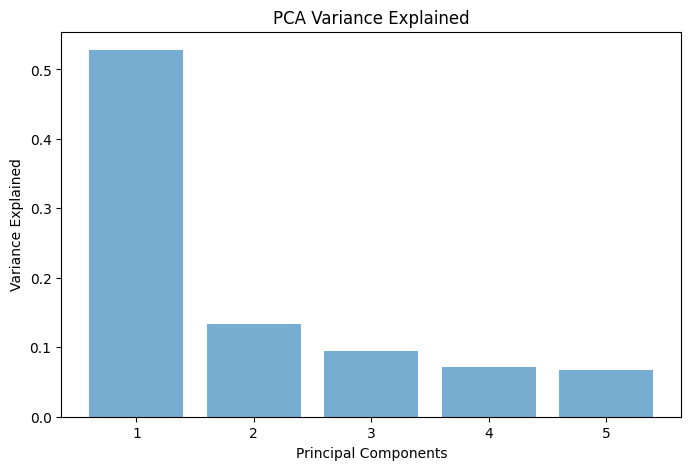

In [12]:
# Step 9: Apply PCA for Dimensionality Reduction
logging.info("Applying PCA for feature reduction...")
numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns.tolist()

if len(numeric_cols) < 5:
    logging.warning("⚠ PCA skipped: Not enough numeric features (need at least 5). Consider adjusting feature selection or outlier thresholds.")
else:
    # Standardize numeric features before PCA
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_df[numeric_cols].fillna(0))
    test_scaled = scaler.transform(test_df[numeric_cols].fillna(0))
    
    # Apply PCA
    pca = PCA(n_components=min(5, len(numeric_cols)))
    train_pca = pca.fit_transform(train_scaled)
    test_pca = pca.transform(test_scaled)
    
    # Convert PCA results into DataFrames
    pca_columns = [f"PCA_{i+1}" for i in range(min(5, len(numeric_cols)))]
    train_pca_df = pd.DataFrame(train_pca, columns=pca_columns, index=train_df.index)
    test_pca_df = pd.DataFrame(test_pca, columns=pca_columns, index=test_df.index)
    
    # Merge PCA results with original data
    train_df = pd.concat([train_df, train_pca_df], axis=1)
    test_df = pd.concat([test_df, test_pca_df], axis=1)
    
    logging.info("PCA explained variance ratio:")
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, min(6, len(numeric_cols) + 1)), pca.explained_variance_ratio_, alpha=0.6)
    plt.xlabel("Principal Components")
    plt.ylabel("Variance Explained")
    plt.title("PCA Variance Explained")
    plt.show()


In [13]:
# Step 10: Optimize Memory Usage
logging.info("Optimizing memory usage...")
numeric_cols = train_df.select_dtypes(include=['float64']).columns
test_numeric_cols = test_df.select_dtypes(include=['float64']).columns
train_df[numeric_cols] = train_df[numeric_cols].astype(np.float32)
test_df[test_numeric_cols] = test_df[test_numeric_cols].astype(np.float32)

display(train_df.head())

display(test_df.head())


2025-03-04 12:09:02,289 - INFO - Optimizing memory usage...


,ticker,simfinid_x,date,open,high,low,close,adj. close,volume,dividend,...,market,main currency,MA_5,MA_20,volatility_10,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
0,A,45846,2019-03-29,80.160004,80.669998,79.949997,80.379997,77.040001,1585137,0.00,...,us,USD,77.040001,77.040001,0.912168,3.066793,-0.878241,-0.295012,-0.056804,-0.265422
1,A,45846,2019-04-01,80.959999,81.769997,80.959999,81.559998,78.330002,1522681,0.16,...,us,USD,77.684998,77.684998,0.912168,3.095377,-1.273721,-0.575253,23.348915,-0.452503
2,A,45846,2019-04-02,81.709999,81.760002,81.029999,81.139999,77.930000,1203037,0.00,...,us,USD,77.766670,77.766670,0.660328,3.112767,-0.847118,-0.352057,-0.055267,-0.266701
3,A,45846,2019-04-03,81.540001,82.019997,81.459999,81.940002,78.699997,2141025,0.00,...,us,USD,78.000000,78.000000,0.713068,3.143475,-0.906560,-0.211493,-0.055009,-0.260661
4,A,45846,2019-04-04,81.839996,82.050003,80.440002,80.830002,77.629997,2180112,0.00,...,us,USD,77.926003,77.926003,0.639320,3.113995,-0.917081,-0.207365,-0.054896,-0.259176


,ticker,simfinid_x,date,open,high,low,close,adj. close,volume,dividend,...,market,main currency,MA_5,MA_20,volatility_10,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
4607138,SEVN,16232553,2021-02-02,11.09,11.18,10.95,11.16,7.53,27347,0.0,...,us,USD,7.380,7.2060,0.071461,-2.094366,1.976140,0.438161,-0.007830,-0.186319
4607139,SEVN,16232553,2021-02-03,11.12,11.38,11.12,11.25,7.59,31109,0.0,...,us,USD,7.442,7.2335,0.104462,-2.087358,1.978064,0.439247,-0.007929,-0.186706
4607140,SEVN,16232553,2021-02-04,11.14,11.27,11.05,11.09,7.48,26727,0.0,...,us,USD,7.466,7.2500,0.104966,-2.090728,1.977697,0.438477,-0.007963,-0.186697
4607141,SEVN,16232553,2021-02-05,11.18,11.38,11.14,11.16,7.53,44150,0.0,...,us,USD,7.498,7.2710,0.110735,-2.086784,1.977397,0.441251,-0.007952,-0.186679
4607142,SEVN,16232553,2021-02-08,11.18,12.00,11.15,11.99,8.09,239590,0.0,...,us,USD,7.644,7.3180,0.233609,-2.060972,1.971573,0.472172,-0.008280,-0.186782


In [14]:
# Step 11: Save Final Cleaned Data
train_df.to_csv("cleaned_stock_data_train.csv", index=False)
test_df.to_csv("cleaned_stock_data_test.csv", index=False)
logging.info("✅ Cleaned train and test datasets saved!")

2025-03-04 12:11:35,237 - INFO - ✅ Cleaned train and test datasets saved!
